In [1]:
# Import needed Python modules 
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

import numpy as np
import copy
import itertools
import multiprocessing

import konrad

In [2]:
atmosphere = konrad.atmosphere.Atmosphere(konrad.utils.get_quadratic_pgrid(1000e2, 10, 64))
atmosphere["CO2"][:] = 280E-6
initial_conds = atmosphere.copy()

#### Compute solutions at varying Ts, RH

In [3]:
Tss = [273, 288, 294, 300, 305]
RHs = [.1, .25, .5, .75, .9]

In [4]:
def run_rce(Ts=300., RH=0.8, co2_scaling=1.):
    """Run an RCE for a given combination of Ts and RH."""
    atmos = initial_conds.copy()
    atmos["CO2"][:] *= co2_scaling
    rce = konrad.RCE(
        atmosphere=initial_conds.copy(),
        surface=konrad.surface.FixedTemperature(temperature=Ts), 
        humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(RH)), 
    )
    rce.run()
    
    return rce

In [5]:
rce_configs = list(itertools.product(Tss, RHs))

with multiprocessing.Pool(processes=2) as pool:
    rce_results = pool.starmap(run_rce, rce_configs)

rces = dict(zip(rce_configs, rce_results))

#### Question 1 
What is the temperature struture of the (tropical) atmosphere under present-day conditions (that's the figure above), and how does this depend on surface temperature and humidity ?

#### Vertical structure of T, q for various T, fixed RH 

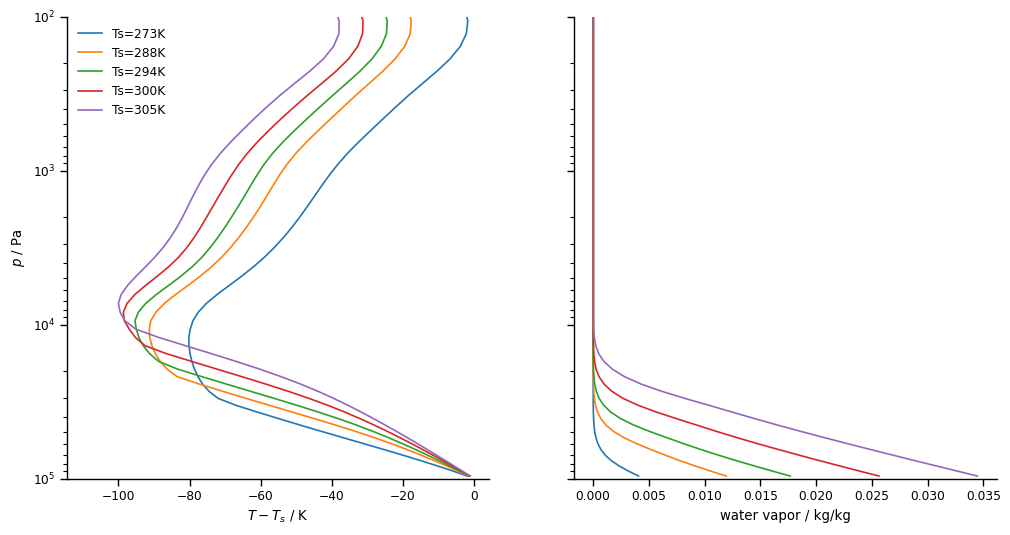

In [6]:
sns.set_context("paper")
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

# Vary temperature at fixed RH = 75%
RH = 0.75
assert (RH in RHs) 
for Ts in Tss:
    ax0.semilogy(rces[(Ts,RH)].atmosphere['T'  ][0,:] - Ts, 
                 rces[(Ts,RH)].atmosphere['plev'], label = "Ts="+str(Ts)+"K")
    ax1.semilogy(rces[(Ts,RH)].atmosphere['H2O'][0,:], rces[(Ts,RH)].atmosphere['plev'])
    

ax0.set_ylim(rces[(Ts,RH)].atmosphere["phlev"][0], 100.) 
ax0.set_ylabel("$p$ / Pa")
ax0.set_xlabel("$T - T_s$ / K")
ax0.legend(frameon = False)

ax1.set_xlabel("water vapor / kg/kg")

sns.despine() 
fig.savefig("State-profiles-vs-T.pdf")

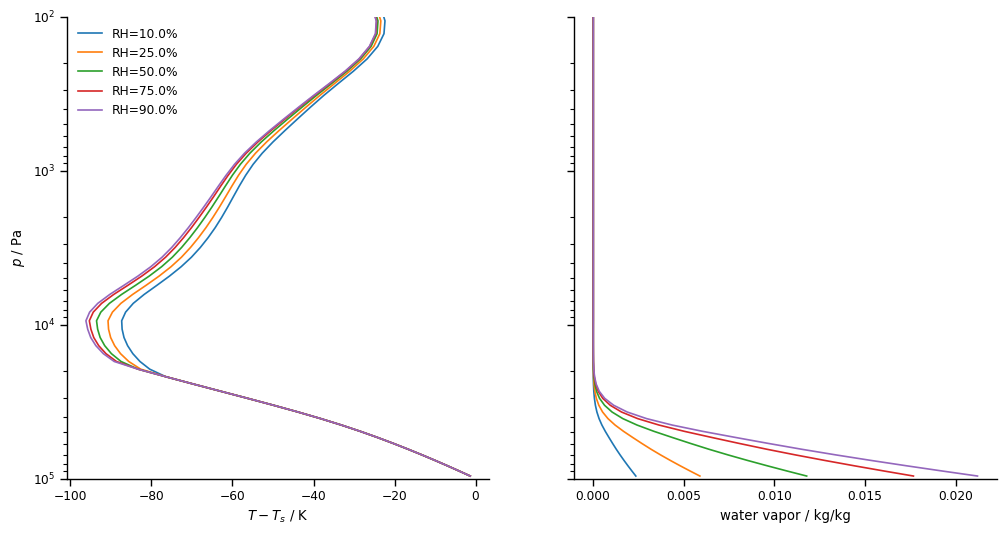

In [7]:
sns.set_context("paper")
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

# Vary temperature at fixed RH = 80%
Ts = 294
assert (Ts in Tss) 
for RH in RHs: 
    ax0.semilogy(rces[(Ts,RH)].atmosphere['T'  ][0,:] - Ts, 
                 rces[(Ts,RH)].atmosphere['plev'], label = "RH="+str(RH*100)+"%")
    ax1.semilogy(rces[(Ts,RH)].atmosphere['H2O'][0,:], rces[(Ts,RH)].atmosphere['plev'])
    

ax0.set_ylim(rces[(Ts,RH)].atmosphere["phlev"][0], 100.) 
ax0.set_ylabel("$p$ / Pa")
ax0.set_xlabel("$T - T_s$ / K")
ax0.legend(frameon = False)

ax1.set_xlabel("water vapor / kg/kg")

sns.despine() 
fig.savefig("State-profiles-vs-RH.pdf")

#### Question 2
What is the instantaneous radiative forcing due to doubling CO$_2$ concentrations from pre-industrial values, and how does this depend on humidity and temperature? 

- Plot the profiles of $F_i$ for the baseline case (see How to Konrad) 
- Plot the dependence of $F_i$ at the top of the atmosphere on surface temperature and/or humidity for several values of each variable

In [8]:
def compute_irf(base, co2_scaling=2): 
    """
    Compute the instantaneous radiative forcing due to scaled CO2 for a konrad RCE solution 
    
    base: konrad RCE solution 
    co2_scaling: real > 0
    """
    # Leave the equilibrium solution unchanged 
    rad = copy.deepcopy(base)
    atmos_scale_co2 = rad.atmosphere.copy() 
    # scale the CO2 concentration
    atmos_scale_co2["CO2"][:] *= co2_scaling
    # Compute new radiation fields with changing temperature or humidity 
    rad.radiation.update_heatingrates(atmosphere=atmos_scale_co2)
    return(rad.radiation["toa"][-1] - base.radiation["toa"][-1])

In [ ]:
sns.set_context("paper")
for RH in RHs: 
    plt.plot(Tss, 
             [compute_irf(rces[(Ts,RH)]) for Ts in Tss], 
             label="RH="+str(RH*100)+"%")
plt.legend(frameon = False) 
plt.xlabel("$T_s$ / K")
plt.ylabel("inst. rad. forcing / W/m-2")
sns.despine()

#### Question 3 
What is the effective radiative forcing due to doubling CO2 concentrations from pre-industrial values, and what is the relationship between stratospheric cooling and the radiative adjustment? 

- Compute the effective radiative forcing for CO$_2$ concentrations doubled from pre-industrial concentrations (e.g. from 280 -> 560 ppmv). Compare the profile of the effective radiative forcing to the profile of instantaneous radiative forcing in question 3. (See How to konrad)
- What fraction of $F$ is the adjustment by stratospheric cooling? 
- Plot the stratospheric adjustment - the change in stratospheric temperature profiles - for 2$\times$CO$_2$ and 0.5$\times$CO$_2$.
- Plot the top-of-atmosphere ERF for several values of surface temperature and/or humidity. Is the dependence the same as for $F_i$? 

In [ ]:
def compute_erf(base, co2_scaling=2): 
    """
    Compute the effective radiative forcing due to scaled CO2 for a konrad RCE solution 
    
    This takes a few seconds 
    
    base: konrad RCE solution 
    co2_scaling: real > 0
    """
    # Copy the atmosphere 
    atmos = base.atmosphere.copy()
    # scale the CO2 concentration
    atmos["CO2"][:] *= co2_scaling
    # Compute new solution  
    rad = konrad.RCE(atmos, 
                     surface=copy.deepcopy (base.surface), 
                     humidity=copy.deepcopy(base.humidity), 
                    )
    rad.run()
    return(rad.radiation["toa"][-1] - base.radiation["toa"][-1])

RH = 0.75
Ts = 294
assert RH in RHs and Ts in Tss
print("ERF for Ts=", Ts, ", RH=", RH*100, "% is ", np.round(compute_erf(rces[(Ts,RH)]), 2), "W/m2")  

In [ ]:
#
# Since the calculation of ERF takes a few seconds while konrad runs to equilibrium, 
#   compute all the 2xCO2 equilibrium solutions just once 
#

def run_2xco2(Ts=300., RH=0.8, co2_scaling=2):
    """Run an RCE with 2xCO2 for a given combination of Ts and RH, 
    assuming a 1xCO2 run exists in variable rces. 
    """
    rce = run_rce(Ts=Ts, RH=RH, co2_scaling=co2_scaling)
    return(rce)

In [ ]:
with multiprocessing.Pool(processes=2) as pool:
    rce_results = pool.starmap(run_2xco2, rce_configs)

rces_2xco2 = dict(zip(rce_configs, rce_results))

In [ ]:
def infer_erf(base, pert): 
    return(pert.radiation["toa"][-1] - base.radiation["toa"][-1]) 

RH=0.75
Ts = 294
assert RH in RHs and Ts in Tss
print("ERF for Ts=", Ts, ", RH=", RH*100, "% is ", np.round(infer_erf(rces[(Ts, RH)], rces_2xco2[(Ts, RH)]), 2), "W/m2")  

In [ ]:
#
# Effective radiative forcing - question 4d
#
sns.set_context("paper")
for RH in RHs: 
    plt.plot(Tss, 
             [infer_erf(rces      [make_key(Ts, RH)],
                        rces_2xco2[make_key(Ts, RH)]) for Ts in Tss], 
             label="RH="+str(RH*100)+"%")
plt.legend(frameon = False) 
plt.xlabel("$T_s$ / K")
plt.ylabel("eff. rad. forcing / W/m-2")
sns.despine()

In [ ]:
#
# Adjustment magnitude 
#
sns.set_context("paper")
for RH in RHs: 
    plt.plot(Tss, 
             [infer_erf(rces      [make_key(Ts, RH)],
                        rces_2xco2[make_key(Ts, RH)]) - 
              compute_irf(rces[make_key(Ts,RH)]) for Ts in Tss], 
             label="RH="+str(RH*100)+"%",
            )
plt.legend(frameon = False) 
plt.xlabel("$T_s$ / K")
plt.ylabel("adjustment / W/m-2")
sns.despine()

In [ ]:
#
# What fraction of ERF is the adjustment? Question 4b
#
sns.set_context("paper")
for RH in RHs: 
    plt.plot(Tss, 
             [(infer_erf(rces      [make_key(Ts, RH)],
                        rces_2xco2[make_key(Ts, RH)]) - compute_irf(rces[make_key(Ts,RH)]))/
              infer_erf(rces      [make_key(Ts, RH)],
                        rces_2xco2[make_key(Ts, RH)]) for Ts in Tss], 
             label="RH="+str(RH*100)+"%",
            )
plt.legend(frameon = False) 
plt.xlabel("$T_s$ / K")
plt.ylabel("adjustment fraction of ERF / W/m-2")
sns.despine()

#### Question 4

What is the climate sensitivity in radiative-convective equlibrium, and how does this depend on humidity and/or initial surface temperature? 

**Climate sensitivity, method 1**

Estimate climate sensitivty by computing the climate feedback and combining this with estimates of forcing by doubled CO2 contentrations. 

- Establish one or more baseline simulations of RCE, similar to those used in question 1, but varying humidity and/or surface temperature.  
- Change the surface temperature, compute the change in top-of-atmosphere net radiation $N$, and the climate feedback $\lambda = \frac{d N}{d T_s}$. Does $\lambda$ depend on humidity or surface temperature? **actually need to run to new equilibrium**
- Estimate climate sensitivity $S$ from the effective radiative forcing (Question 3) and the climate feedback $S = \frac{F_{2\times CO_2}}{\lambda}$
<a id='S_from_lambda_F'></a>

In [ ]:
#
# Simulations with surface temperature incremented by 1K 
#
rces_plus1 = {}
for Ts in Tss:
    for RH in RHs: 
        k = make_key(T=Ts, RH=RH)
        rces_plus1[k] = konrad.RCE(rces[k].atmosphere.copy(), 
                             surface=konrad.surface.FixedTemperature(temperature=Ts+1), 
                             humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(RH)), 
        )
        
for k in tqdm(rces_plus1.keys()): 
    rces_plus1[k].run()

In [ ]:
def compute_cess_s(base, twoxco2, plus1): 
    fb = plus1.radiation["toa"][-1] - base.radiation["toa"][-1]
    fc = infer_erf(base, twoxco2)
    return(-fc/fb) 

sns.set_context("paper")
for RH in RHs: 
    plt.plot(Tss, 
             [compute_cess_s(rces      [make_key(Ts,RH)], 
                             rces_2xco2[make_key(Ts,RH)],
                             rces_plus1[make_key(Ts,RH)]) for Ts in Tss], 
             label="RH="+str(RH*100)+"%")
plt.legend(frameon = False) 
plt.xlabel("$T_s$ / K")
plt.ylabel("Cess climate sens. / K")
plt.ylim(0, 6)
sns.despine()

**Climate sensitivity, method 2**

Another way to compute climate sensitity is by changing CO$_2$ concentrations and running to equilibrium while letting the surface temperature evolve. For this we have to specify a different model of the surface: a "slab ocean", meaning a heat resevoir scaled to the capacity of a shallow layer of water, with a heat sink that allows the model to come into balance with a specified surface temperature. From 

In [ ]:
#
#  Run the model with specified surface temperature to compute the total imbalance 
#c
fixed_SST = konrad.RCE(
    initial_conds.copy(),
    surface=konrad.surface.FixedTemperature(temperature=295.0),
)
fixed_SST.run()  
print("Near-surface temp with fixed surface temperature:  ", f'{fixed_SST.atmosphere   ["T"][0, 0]:6.4}') 

ml_ocean = konrad.surface.SlabOcean(
    temperature=295.0,
    heat_sink=fixed_SST.radiation["toa"][-1],
    depth=10.,
)

#
# A slab ocean model with a heat sink that matches the imbalance should have nearly the same surface air temperature 
#
slab_ocean = konrad.RCE(
    fixed_SST.atmosphere.copy(),
    surface=ml_ocean,
    timestep='12h',
    max_duration='300d',  # Set runtime.
)
slab_ocean.run()
print("Near-surface temp with slab ocean:", f'{slab_ocean.atmosphere["T"][0, 0]:6.4}') 


- From the baseline simulations, increasing $CO_2$ concentrations by a factor of 2 and run to equilibrium. (See [How to konrad](https://atmtools.github.io/konrad/feedback.html)) How long must you run the simulation for the temperature to equilibrate (reach a stable value?)
- How do estimates of $S$ compare to those estimated [more indirectly](#S_from_lambda_F)? 
- How do estimates of $\lambda$ inferred from $S$ and $F$ compare to those estimated from changing surface temperature? 